# ⚕ Локализация белков внутри клетки

В этом примере рассматривается задача классификации, когда целевая переменная может принимать более двух значений, то есть многоклассовая классификация.

В библиотеке `scikit-learn` большинство алгоритмов уже изначально умеют работать с несколькими классами, при этом модуль `sklearn.multiclass` содержит несколько дополнительных подходов, которые можно использовать для экспериментов или при разработке собственных моделей, поддерживающих только бинарную классификацию.

В частности, модуль sklearn.multiclass реализует стратегии OvO (One-vs-One) и OvR (One-vs-Rest), позволяющие обучить многоклассовый классификатор через набор бинарных моделей.
За это отвечают метаоценщики (meta-estimators)
`sklearn.multiclass.OneVsOneClassifier` и `sklearn.multiclass.OneVsRestClassifier`.


## Этап 0: загрузка данных и EDA

Сегодня мы будем работать с одним из классических биоинформатических датасетов из репозитория [UCI Machine Learning Repository](https://archive.ics.uci.edu/), известный как **Yeast** (дрожжи).

Задача заключается в предсказании локализации белков внутри клетки — то есть, нужно определить, в какой части клетки находится данный белок. Такая задача обычно решается в ходе биомедицинских исследований и позволяет, например, находить "мишени" для лекарств.

Каждый белок представлен рядом числовых признаков, рассчитанных на основе его аминокислотной последовательности (например, частоты определенных остатков, сигналы гидрофобности, физико-химические характеристики и т. д.).

**Основные характеристики набора данных**

Количество объектов (образцов): 1 484 белка

Количество признаков: 8 вещественных числовых признаков

Целевая переменная: тип внутриклеточной локализации (многоклассовая метка)

Количество классов: 10

- CYT — цитозоль

- NUC — ядро

- MIT — митохондрия

- ME3 — мембрана (endoplasmic reticulum)

- EXC — внеклеточное пространство

- VAC — вакуоль

- ... и другие


На [странице датасета](https://archive.ics.uci.edu/dataset/110/yeast) можем посмотреть что означает каждый из признаков:


![image.png](https://storage.yandexcloud.net/ml-course-images/Yeast%20dataset%20features.png)

Мы загрузим датасет с платформы [OpenML](https://www.openml.org/), воспользовавшись функцией `sklearn.datasets.fetch_openml`.

In [ ]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

sns.set(style="whitegrid", context="notebook")

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

###Загрузка данных

In [ ]:
X, y = fetch_openml(data_id=181, as_frame=True, return_X_y=True)

Для проведения EDA объединим признаки и целевую переменную

In [ ]:
df = pd.concat([X, y.rename("class")], axis=1)
df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


### Численные характеристики признаков

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mcg     1484 non-null   float64
 1   gvh     1484 non-null   float64
 2   alm     1484 non-null   float64
 3   mit     1484 non-null   float64
 4   erl     1484 non-null   float64
 5   pox     1484 non-null   float64
 6   vac     1484 non-null   float64
 7   nuc     1484 non-null   float64
dtypes: float64(8)
memory usage: 92.9 KB


In [ ]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
mcg,1484.0,0.500121,0.137299,0.11,0.41,0.49,0.58,1.00
gvh,1484.0,0.499933,0.123924,0.13,0.42,0.49,0.57,1.00
alm,1484.0,0.500034,0.086670,0.21,0.46,0.51,0.55,1.00
mit,1484.0,0.261186,0.137098,0.00,0.17,0.22,0.32,1.00
erl,1484.0,0.504717,0.048351,0.50,0.50,0.50,0.50,1.00
pox,1484.0,0.007500,0.075683,0.00,0.00,0.00,0.00,0.83
vac,1484.0,0.499885,0.057797,0.00,0.48,0.51,0.53,0.73
nuc,1484.0,0.276199,0.106491,0.00,0.22,0.22,0.30,1.00


### Распределение таргета, сбалансированность классов

In [ ]:
y.value_counts().sort_index()

,count
class_protein_localization,
CYT,463
ERL,5
EXC,35
ME1,44
ME2,51
ME3,163
MIT,244
NUC,429
POX,20


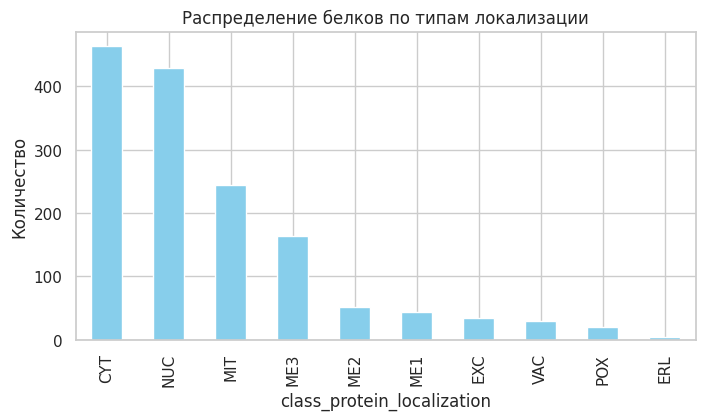

,proportion
class_protein_localization,
CYT,0.312
NUC,0.289
MIT,0.164
ME3,0.110
ME2,0.034
ME1,0.030
EXC,0.024
VAC,0.020
POX,0.013


In [ ]:
plt.figure(figsize=(8,4))
y.value_counts().plot(kind='bar', color='skyblue')
plt.title("Распределение белков по типам локализации")
plt.ylabel("Количество")
plt.show()

y.value_counts(normalize=True).round(3)


**Вопрос**: Что нужно будет честь в дальнейшем, исходя из полученной информации о распределении?

### Корреляция между признаками

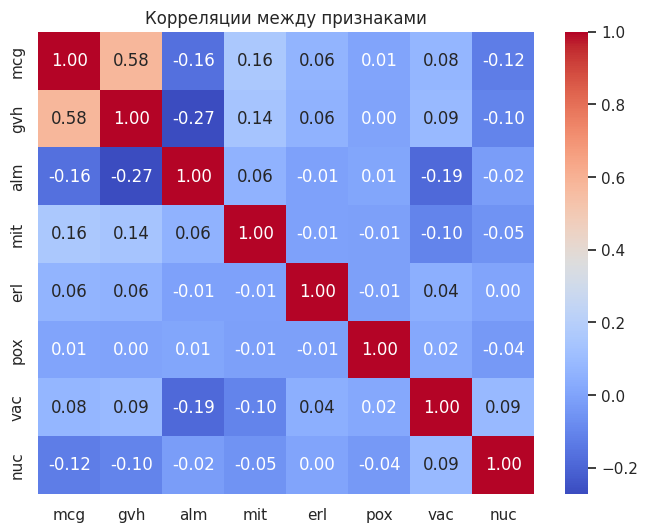

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляции между признаками")
plt.show()


**Вопрос:** Какие выводы можно сделать исходя из полученной матрицы корреляции?

### Распределение признаков

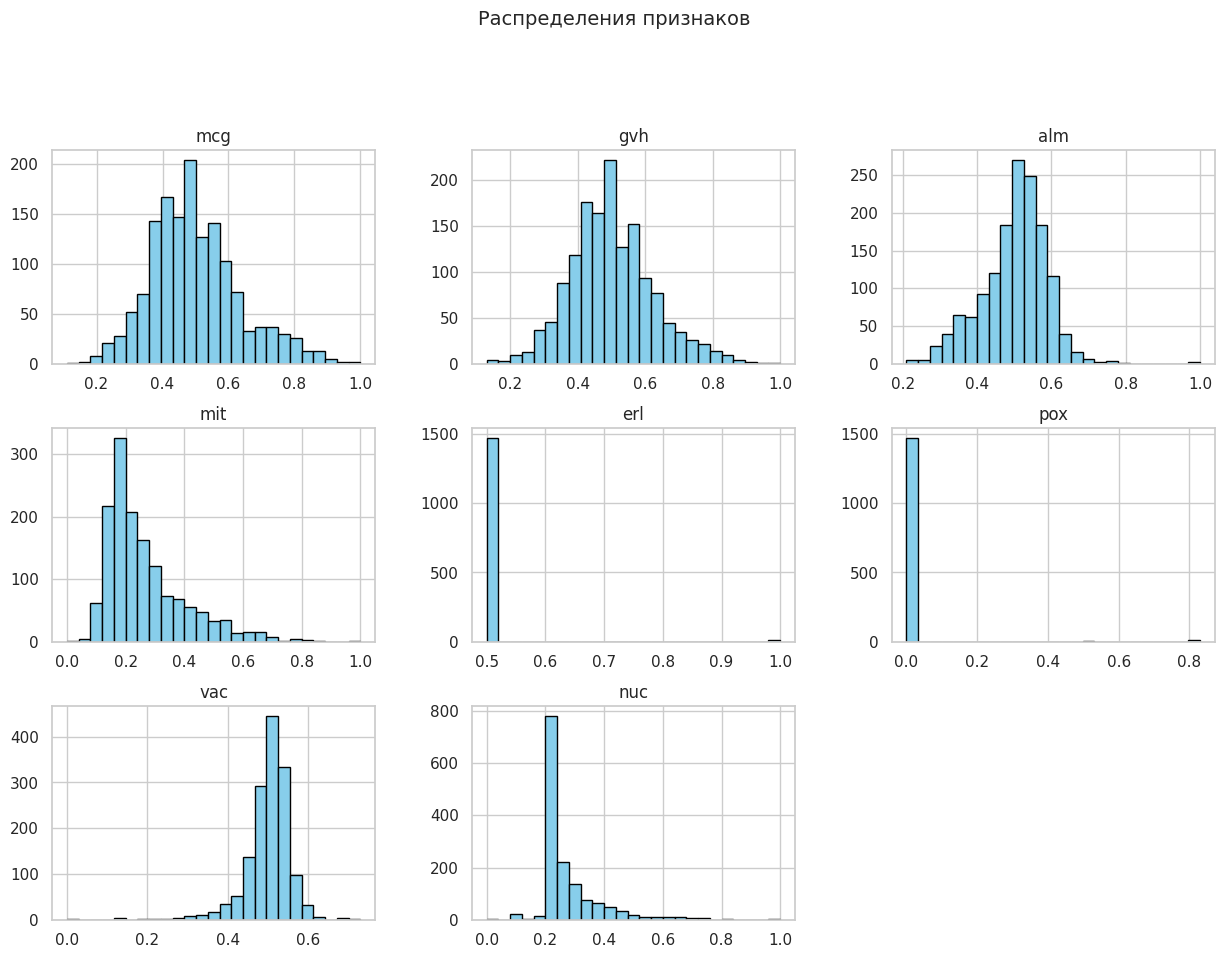

In [ ]:
X.hist(bins=25, figsize=(15,10), color="skyblue", edgecolor="black")
plt.suptitle("Распределения признаков", fontsize=14, y=1.02)
plt.show()


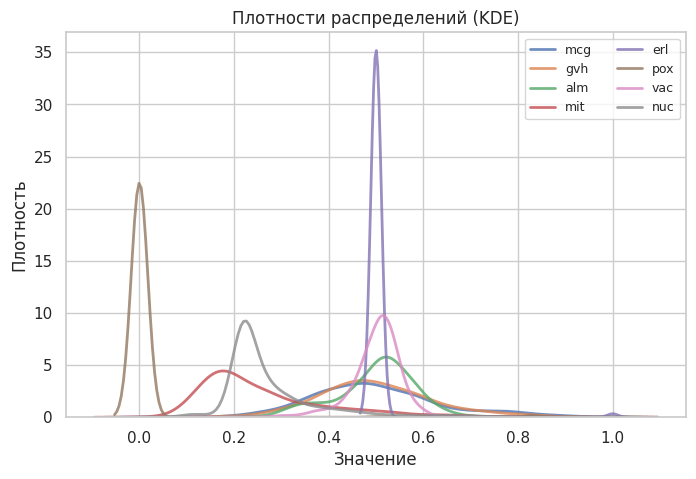

In [ ]:
plt.figure(figsize=(8, 5))
for col in X:
    sns.kdeplot(X[col], label=col, linewidth=2, alpha=0.8)
plt.title("Плотности распределений (KDE)")
plt.xlabel("Значение")
plt.ylabel("Плотность")
plt.legend(ncol=2, fontsize=9)
plt.show()

### Распределение принаков по классам

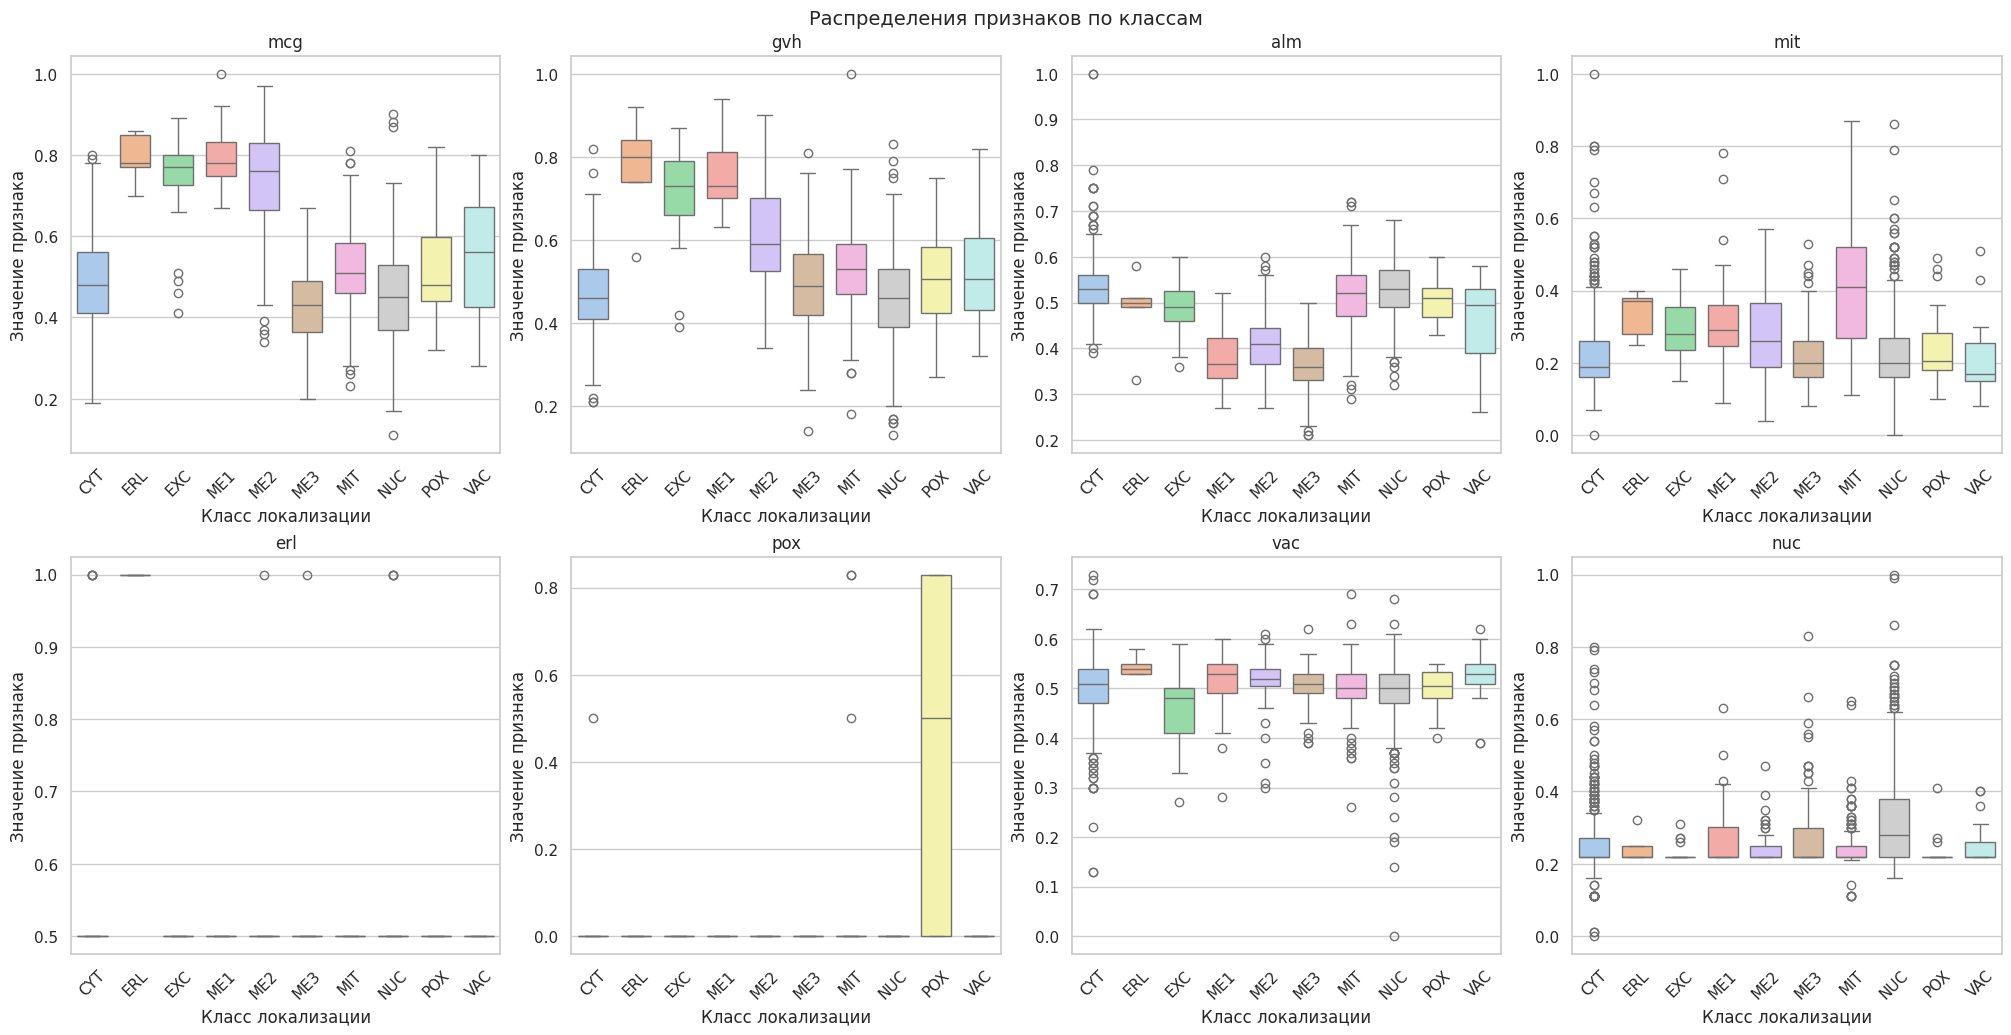

In [ ]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    figsize=(20, 10),
    layout="constrained"
)

axes = axes.ravel()

for ax, col in zip(axes, X.columns):
    sns.boxplot(
        data=df,
        x="class", y=col,
        hue="class",
        legend=False,
        ax=ax,
        palette="pastel",
        width=0.7,
    )
    ax.set_title(col, fontsize=12)
    ax.tick_params(axis="x", rotation=45)
    ax.set_xlabel("Класс локализации")
    ax.set_ylabel("Значение признака")


fig.suptitle("Распределения признаков по классам", fontsize=14, y=1.02)
plt.show()


###Структура данных

Метод главных компонент (PCA) — это способ упростить многомерные данные,
сжав информацию в несколько наиболее информативных направлений (компонент).
Сам метод подробно мы будем проходить позже, а сейчас мы используем его только для визуализации: каждый белок представлен точкой, а две оси (PC1 и PC2) показывают комбинации исходных признаков, которые объясняют наибольшую часть вариации данных

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Объясненная дисперсия по компонентам: PC1 = 22.68%, PC2 = 15.88%
Суммарно: 38.56%


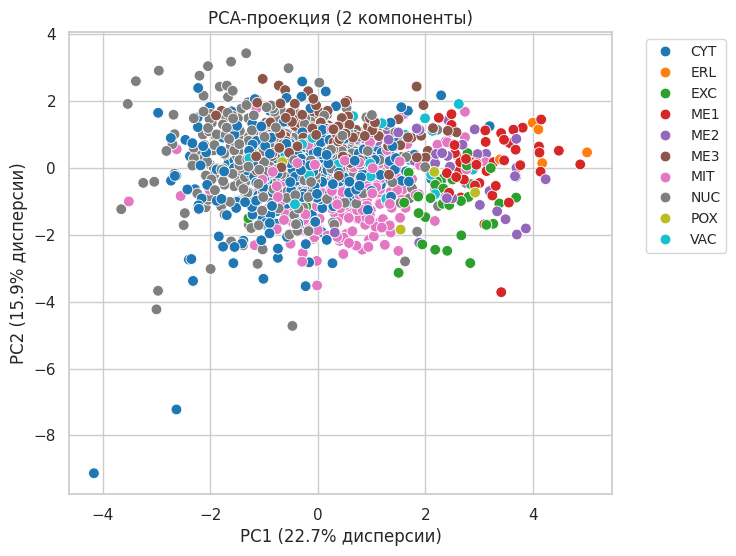

In [ ]:
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Объясненная дисперсия
explained = pca.explained_variance_ratio_ * 100
print(f"Объясненная дисперсия по компонентам: PC1 = {explained[0]:.2f}%, PC2 = {explained[1]:.2f}%")
print(f"Суммарно: {explained.sum():.2f}%")

plt.figure(figsize=(7, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='tab10', s=60)
plt.title("PCA-проекция (2 компоненты)")
plt.xlabel(f"PC1 ({explained[0]:.1f}% дисперсии)")
plt.ylabel(f"PC2 ({explained[1]:.1f}% дисперсии)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show();


С помощью библиотеки `plotly` можем отрисовать трехмерную интерактивную визуализацию на три компоненты

In [ ]:
import plotly.express as px

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Объясненная дисперсия
expl = pca.explained_variance_ratio_ * 100
print(f"Объясненная дисперсия по компонентам: {expl.round(2)}%")
print(f"Суммарно: {expl.sum():.2f}%")


df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
df_pca["class"] = y

# 3D визуализация
fig = px.scatter_3d(
    df_pca,
    x="PC1", y="PC2", z="PC3",
    color="class",
    color_discrete_sequence=px.colors.qualitative.T10,
    title="PCA-проекция (3 компоненты)",
    width=800, height=600,
)


fig.update_layout(
    scene=dict(
        xaxis_title=f"PC1 ({expl[0]:.1f}% дисперсии)",
        yaxis_title=f"PC2 ({expl[1]:.1f}% дисперсии)",
        zaxis_title=f"PC3 ({expl[2]:.1f}% дисперсии)"
    ),
    title_x=0.5
)

fig.show();

Объясненная дисперсия по компонентам: [22.68 15.88 12.77]%
Суммарно: 51.32%


## Стратегии многоклассовой классификации: OvR и OvO для SVM

Для решения задачи мы будем использовать метод опорных векторов (SVM).

Поскольку SVM изначально предназначен для бинарной классификации, библиотека scikit-learn при применении его к многоклассовой задаче автоматически использует встроенную стратегию преобразования задачи. Встроенная задача базируется на стратегии One-Vs-One, но мы проверим, одинаковыми ли будут результаты.

Помимо этой встроенной реализации, мы рассмотрим две стратегии,
обсуждавшиеся на лекции: One-vs-Rest (OvR) и One-vs-One (OvO), реализованные в sklearn отдельными классами.


Прежде всего при сравнении подходов мы будем смотреть на показатель Accuracy, как на базовый, но далее нам понадобятся и другие метрики. Зададим их заранее для всех экспериментов.

In [ ]:
scoring = [
    "accuracy",
    "balanced_accuracy",
    "precision_macro",
    "recall_macro",
    "f1_macro",
    "precision_micro",
    "recall_micro",
    "f1_micro",
    "precision_weighted",
    "recall_weighted",
    "f1_weighted",
]

В дополнение к тем метрикам, которые мы рассмотрели на лекции, мы добавили [balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html). Метрика используется для задач бинарной и многоклассовой классификации при работе с несбалансированными выборками и определяется как среднее значение полноты (recall), вычисленной по каждому классу.

##Этап I: Baseline

In [ ]:
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    cross_validate
)

from sklearn.multiclass import (
    OneVsOneClassifier,
    OneVsRestClassifier,
)

from sklearn.svm import SVC

In [ ]:
# Кросс-валидация
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=0)

# Базовая модель SVM
svm = SVC(kernel="linear", C=1.0, random_state=0)

# Разные стратегии многоклассовой классификации
ovo_svm = OneVsOneClassifier(svm)
ovr_svm = OneVsRestClassifier(svm)

# Оценка через кросс-валидацию
cv_results_svm = cross_validate(svm, X, y, cv=cv, n_jobs=3, scoring=scoring)
cv_results_ovo = cross_validate(ovo_svm, X, y, cv=cv, n_jobs=3, scoring=scoring)
cv_results_ovr = cross_validate(ovr_svm, X, y, cv=cv, n_jobs=3, scoring=scoring)

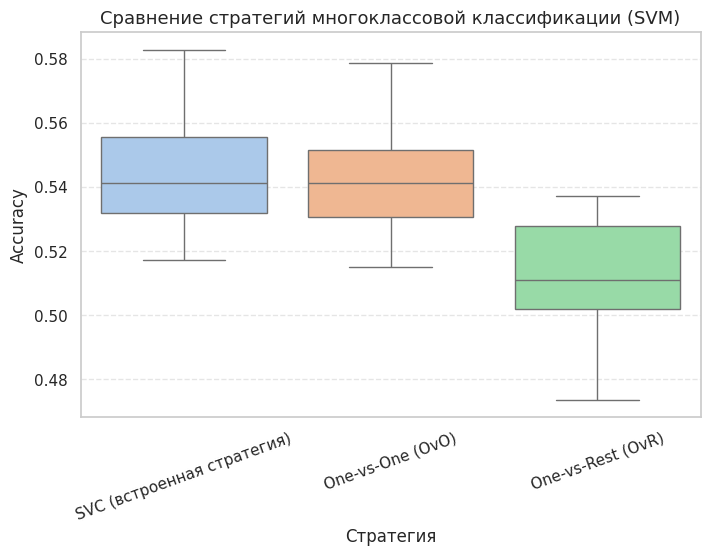

,mean,std
SVC (встроенная стратегия),0.545,0.018
One-vs-One (OvO),0.543,0.018
One-vs-Rest (OvR),0.512,0.019


In [ ]:
results = pd.DataFrame({
    "SVC (встроенная стратегия)": cv_results_svm["test_accuracy"],
    "One-vs-One (OvO)": cv_results_ovo["test_accuracy"],
    "One-vs-Rest (OvR)": cv_results_ovr["test_accuracy"]
    })

# Преобразуем для удобства визуализации
results_melted = results.melt(var_name="Стратегия", value_name="Accuracy")

# Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(data=results_melted, x="Стратегия", y="Accuracy", hue="Стратегия", legend=False, palette="pastel")
plt.title("Сравнение стратегий многоклассовой классификации (SVM)", fontsize=13)
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# Таблица средних значений Accuracy
display(results.describe().T[["mean", "std"]].round(3))


##Этап II: Учет дисбаланса классов

При несбалансированных классах можно также добавить параметр `class_weight="balanced"`.  
Сравним результат.

In [ ]:
# Кросс-валидация
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=0)

# Базовая модель SVM
svm_balanced = SVC(kernel="linear", C=1.0, class_weight="balanced", random_state=0)

# Разные стратегии многоклассовой классификации
ovo_svm_balanced = OneVsOneClassifier(svm_balanced)
ovr_svm_balanced = OneVsRestClassifier(svm)

# Оценка через кросс-валидацию
cv_results_svm_balanced = cross_validate(svm_balanced, X, y, cv=cv, n_jobs=3, scoring=scoring)
cv_results_ovo_balanced = cross_validate(ovo_svm_balanced, X, y, cv=cv, n_jobs=3, scoring=scoring)
cv_results_ovr_balanced = cross_validate(ovr_svm_balanced, X, y, cv=cv, n_jobs=3, scoring=scoring)

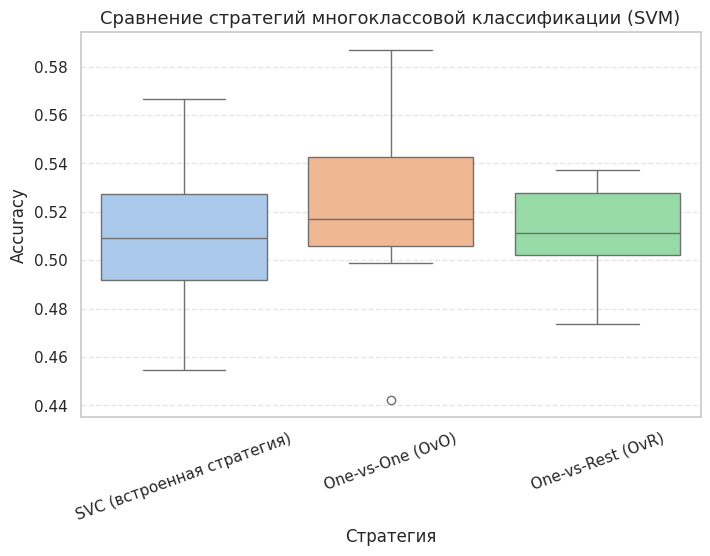

,mean,std
SVC (встроенная стратегия),0.511,0.033
One-vs-One (OvO),0.524,0.035
One-vs-Rest (OvR),0.512,0.019


In [ ]:
results_balanced = pd.DataFrame({
    "SVC (встроенная стратегия)": cv_results_svm_balanced["test_accuracy"],
    "One-vs-One (OvO)": cv_results_ovo_balanced["test_accuracy"],
    "One-vs-Rest (OvR)": cv_results_ovr_balanced["test_accuracy"]
    })

# Преобразуем для удобства визуализации
results_balanced_melted = results_balanced.melt(var_name="Стратегия", value_name="Accuracy")

# Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(data=results_balanced_melted, x="Стратегия", y="Accuracy", hue="Стратегия", legend=False, palette="pastel")
plt.title("Сравнение стратегий многоклассовой классификации (SVM)", fontsize=13)
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


# Таблица средних значений Accuracy
display(results_balanced.describe().T[["mean", "std"]].round(3))

## Этап III: Сравнение и выводы

Выведем результаты двух экспериментов для наглядности

In [ ]:
def pack_results(cv_dicts, strategy_names, balanced_flag):
    df = pd.DataFrame({name: cv["test_accuracy"] for name, cv in zip(strategy_names, cv_dicts)})
    df = df.melt(var_name="Стратегия", value_name="Accuracy")
    df["Балансировка"] = balanced_flag
    return df

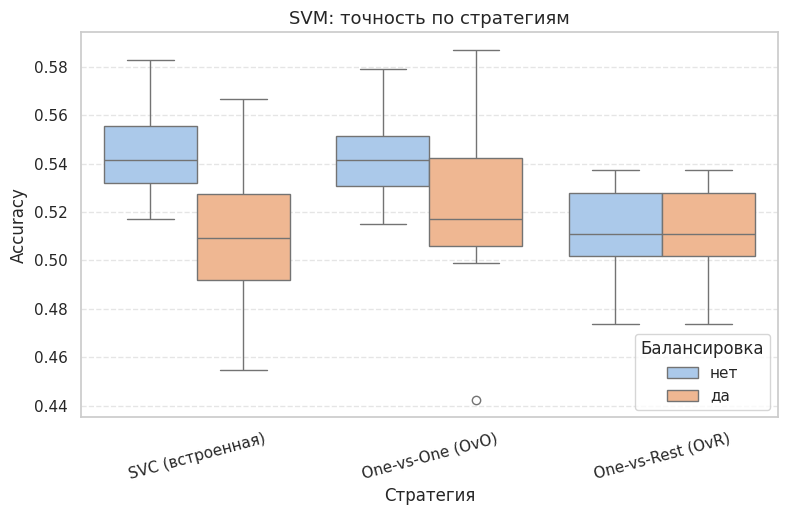

,Стратегия,Балансировка,mean_accuracy,std
0,One-vs-One (OvO),да,0.524,0.035
1,One-vs-One (OvO),нет,0.543,0.018
2,One-vs-Rest (OvR),да,0.512,0.019
3,One-vs-Rest (OvR),нет,0.512,0.019
4,SVC (встроенная),да,0.511,0.033
5,SVC (встроенная),нет,0.545,0.018


In [ ]:
strategy_order = ["SVC (встроенная)", "One-vs-One (OvO)", "One-vs-Rest (OvR)"]
hue_order      = ["нет", "да"]

res = pack_results(
    cv_dicts=[cv_results_svm, cv_results_ovo, cv_results_ovr],
    strategy_names=strategy_order,
    balanced_flag="нет",
)
res_bal = pack_results(
    cv_dicts=[cv_results_svm_balanced, cv_results_ovo_balanced, cv_results_ovr_balanced],
    strategy_names=strategy_order,
    balanced_flag="да",
)

results_compare = pd.concat([res, res_bal], ignore_index=True)

plt.figure(figsize=(9,5))
sns.boxplot(
    data=results_compare,
    x="Стратегия", y="Accuracy",
    hue="Балансировка",
    order=strategy_order,
    hue_order=hue_order,
    palette="pastel"
)
plt.title("SVM: точность по стратегиям", fontsize=13)
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(title="Балансировка", loc="lower right")
plt.show()

# Barplot
means = (results_compare
         .groupby(["Стратегия","Балансировка"])["Accuracy"]
         .agg(["mean","std"])
         .reset_index())

# сводка
display(means.rename(columns={"mean":"mean_accuracy","std":"std"}).round(3))


Метрика Accuracy **снизилась**, хотя мы хотели улучшить результаты.

**Вопрос:** Почему так получилось?

In [ ]:
def summarize(cvres, name):
    cols = [c for c in cvres.keys() if c.startswith("test_")]
    s = {c.replace("test_", ""): cvres[c].mean() for c in cols}
    return pd.Series(s, name=name).round(3)

In [ ]:
summary = pd.concat([
    summarize(cv_results_svm, "SVC"),
    summarize(cv_results_svm_balanced, "SVC (balanced)"),
    summarize(cv_results_ovo, "OvO"),
    summarize(cv_results_ovo_balanced, "OvO (balanced)"),
    summarize(cv_results_ovr, "OvR"),
    summarize(cv_results_ovr_balanced, "OvR (balanced)")
], axis=1).T

display(summary)

,accuracy,balanced_accuracy,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro,precision_weighted,recall_weighted,f1_weighted
SVC,0.545,0.373,0.408,0.373,0.363,0.545,0.545,0.545,0.556,0.545,0.511
SVC (balanced),0.511,0.576,0.510,0.576,0.506,0.511,0.511,0.511,0.588,0.511,0.516
OvO,0.543,0.366,0.410,0.366,0.362,0.543,0.543,0.543,0.553,0.543,0.509
OvO (balanced),0.524,0.569,0.507,0.569,0.504,0.524,0.524,0.524,0.588,0.524,0.535
OvR,0.512,0.471,0.488,0.471,0.445,0.512,0.512,0.512,0.518,0.512,0.470
OvR (balanced),0.512,0.471,0.488,0.471,0.445,0.512,0.512,0.512,0.518,0.512,0.470


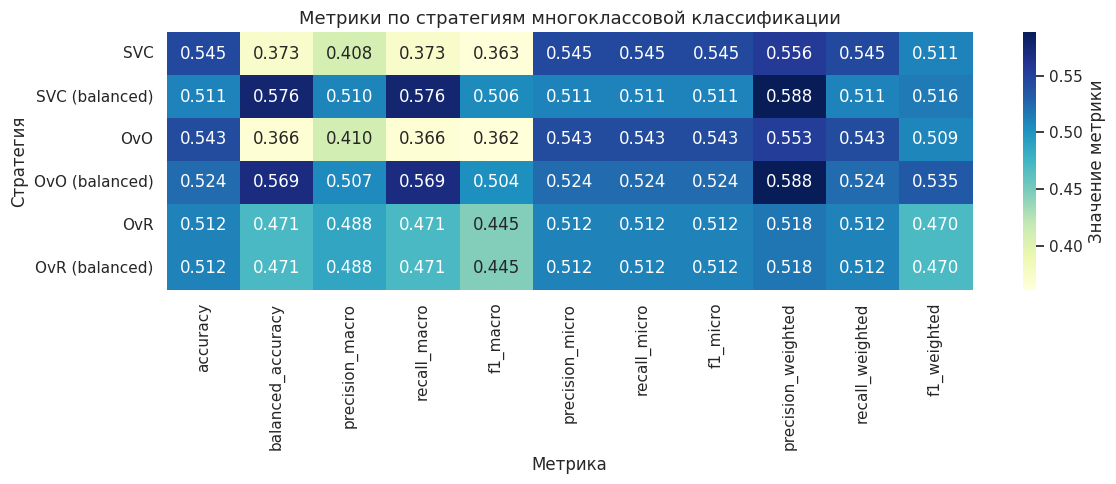

In [ ]:
row_order = [
    "SVC", "SVC (balanced)",
    "OvO", "OvO (balanced)",
    "OvR", "OvR (balanced)",
]

heatmap_data = summary.loc[row_order, scoring]

plt.figure(figsize=(12, 5))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    cbar_kws={"label": "Значение метрики"}
)
plt.title("Метрики по стратегиям многоклассовой классификации", fontsize=13)
plt.xlabel("Метрика")
plt.ylabel("Стратегия")
plt.tight_layout()
plt.show()


Accuracy (общая точность) действительно снизилась, но выросли метрики, чувствительные к дисбалансу классов: precision, recall, F1 с макроусредненем, balanced_accuracy и weighted_precision. При добавлении `class_weight='balanced'` модель стала более справедливой: теперь она лучше классифицирует редкие классы, хотя это немного ухудшает точность по частым

**Вопрос:** Мы повысили справедливость модели, но в целом метрика около 0,5 не может считаться хорошей. Почему мы получили такие низкие результаты и что можно попробовать сделать в будущем, чтобы повысить качество модели?